# 00. 라이브러리 임포트

In [1]:
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import gower
from kmodes.kprototypes import KPrototypes
from scipy.cluster.hierarchy import dendrogram, fcluster, linkage
from scipy.spatial.distance import pdist, squareform
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    silhouette_score,
    calinski_harabasz_score,
    pairwise_distances,
)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# Warnings & matplotlib font settings
warnings.filterwarnings('ignore')

# plt.rcParams['font.family'] = 'Malgun Gothic'    # 윈도우
plt.rcParams['font.family'] = 'AppleGothic'        # 맥
# plt.rcParams['font.family'] = 'NanumGothic'      # 리눅스
plt.rcParams['axes.unicode_minus'] = False         # 마이너스(-) 깨짐 방지

# 01. 데이터 로드

In [2]:
df = pd.read_csv('../data/processed/selected_features.csv')
print(f"데이터 형태: {df.shape}")

데이터 형태: (2591, 10)


# 02. 군집분석 데이터 정제

In [3]:
# 연속형/범주형으로 분리
col_num = 8
cols_list = ["MDAY전체TOT_RAW61", "M일HAP_61", "MVIT", "Q8a06", "Q8a07", "Q9_5A7", "Q8_1a5", "Q8_1a6", "Q8_1a3", "Q8_1a2"]

num_cols = cols_list[:3]   # 연속형
cat_cols = cols_list[3:col_num]   # 이진/범주형

X = df[num_cols + cat_cols].dropna().copy()

# 연속형만 StandardScaler
scaler = StandardScaler()
X_num = pd.DataFrame(scaler.fit_transform(X[num_cols]), columns=num_cols, index=X.index)

X_cat = X[cat_cols].astype(int)

# 결합
X_pre = pd.concat([X_num, X_cat], axis=1)

# k-prototypes 입력
X_mat = X_pre.values
cat_idx = [X_pre.columns.get_loc(c) for c in cat_cols]

# 03. 군집 수 k 결정

In [4]:
k_candidates = [3, 4, 5, 6] # 군집 수 후보
gamma_candidates = [0.3, 0.5, 0.8]  # 범주형 가중치 후보

rows = []
for k in k_candidates:
    for gamma in gamma_candidates:
        kp = KPrototypes(
            n_clusters=k, init='Huang', n_init=7,
            random_state=42, verbose=0, gamma=gamma
        )
        lbl = kp.fit_predict(X_mat, categorical=cat_idx)
        rows.append((k, gamma, kp.cost_, np.bincount(lbl)))
res_df = pd.DataFrame(rows, columns=["k","gamma","cost","size_dist"]).sort_values(["k","gamma"])
print(res_df)

    k  gamma         cost                        size_dist
0   3    0.3  5182.775235                 [283, 2100, 208]
1   3    0.5  5886.926959                 [2048, 233, 310]
2   3    0.8  6949.873933                 [277, 2073, 241]
3   4    0.3  3920.632239            [151, 2068, 118, 254]
4   4    0.5  4627.426202            [2069, 152, 118, 252]
5   4    0.8  5687.632239            [151, 2068, 118, 254]
6   5    0.3  3445.481142       [1626, 143, 118, 166, 538]
7   5    0.5  3956.091399       [1361, 142, 244, 118, 726]
8   5    0.8  4623.582885       [742, 292, 138, 118, 1301]
9   6    0.3  3055.399523   [59, 1303, 165, 455, 119, 490]
10  6    0.5  3573.938837  [165, 406, 126, 118, 656, 1120]
11  6    0.8  4214.933639   [380, 117, 53, 222, 1099, 720]


In [5]:
def gower_silhouette(X_df, labels):
    D = gower.gower_matrix(X_df)
    # 대각선을 0으로 보정
    np.fill_diagonal(D, 0.0)
    # silhouette 계산
    sil = silhouette_score(D, labels, metric="precomputed")
    return sil

scores = []
for k in [3,4]:
    for gamma in [0.3, 0.5, 0.8]:
        kp = KPrototypes(
            n_clusters=k, init='Huang', n_init=10,
            random_state=42, verbose=0, gamma=gamma
        )
        lbl = kp.fit_predict(X_mat, categorical=cat_idx)
        sil = gower_silhouette(X_pre, lbl)
        sizes = np.bincount(lbl)
        scores.append((k, gamma, sil, sizes.min()/len(lbl)))
sel = pd.DataFrame(scores, columns=["k","gamma","silhouette","min_cluster_ratio"]).sort_values(["k","silhouette"], ascending=[True, False])
print(sel)

   k  gamma  silhouette  min_cluster_ratio
0  3    0.3    0.067928           0.080278
1  3    0.5    0.062851           0.089927
2  3    0.8    0.062180           0.093014
5  4    0.8    0.002167           0.045542
3  4    0.3    0.001812           0.045542
4  4    0.5    0.001812           0.045542


# 04. 군집 분석

In [6]:
# k=3, gamma=0.3 선택
best_k = 3  
best_gamma = 0.3

kp_final = KPrototypes(
    n_clusters=best_k, init='Huang', n_init=15,
    random_state=42, verbose=0, gamma=best_gamma
)
labels = kp_final.fit_predict(X_mat, categorical=cat_idx)
df_with_cluster = df[num_cols + cat_cols].dropna().copy()
df_with_cluster["cluster"] = pd.Series(labels, index=X_pre.index)

g = df_with_cluster.loc[X_pre.index].groupby("cluster")
prof_num = g[num_cols].mean().add_suffix("_mean")
prof_cat = g[cat_cols].mean().add_suffix("_rate")
size = g.size().to_frame("size")

cluster_profile = pd.concat([size, prof_num, prof_cat], axis=1).sort_index()
display(cluster_profile.round(3))

,size,MDAY전체TOT_RAW61_mean,M일HAP_61_mean,MVIT_mean,Q8a06_rate,Q8a07_rate,Q9_5A7_rate,Q8_1a5_rate,Q8_1a6_rate
cluster,,,,,,,,,
0,283,115.960,25.855,3.700,0.293,0.399,0.495,0.279,0.138
1,2100,272.014,7.266,1.918,0.336,0.364,0.156,0.374,0.150
2,208,888.583,5.514,6.043,0.183,0.236,0.082,0.284,0.101


# 05. 결과 저장

In [7]:
# 결과 저장
cluster_profile.to_csv('../output/cluster_profile.csv', index=True)
df_with_cluster.to_csv('../output/clustered_data.csv', index=False)

# 06. 시각화

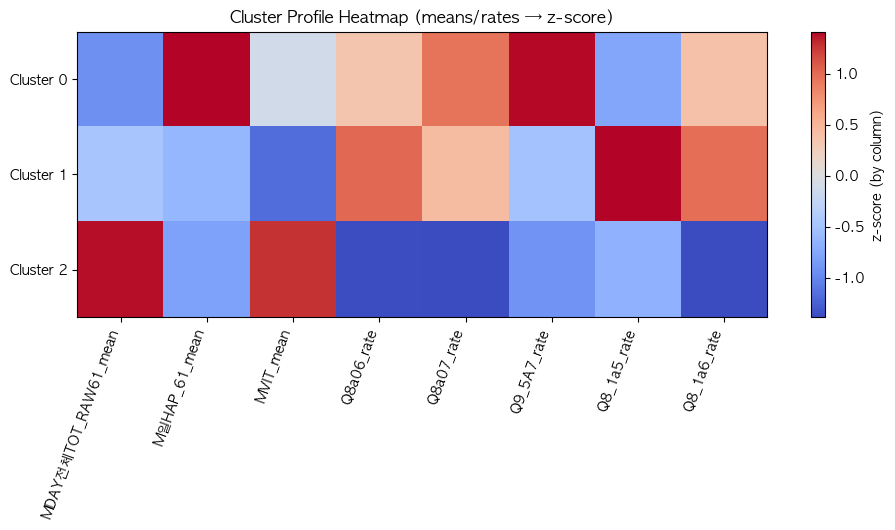

Cluster sizes:
cluster
0     283
1    2100
2     208
Name: size, dtype: int64


In [8]:
# 프로파일 만들기
g = df_with_cluster.dropna(subset=["cluster"]).groupby("cluster")
prof_num = g[num_cols].mean().add_suffix("_mean")
prof_cat = g[cat_cols].mean().add_suffix("_rate")
size = g.size().to_frame("size")
profile = pd.concat([size, prof_num, prof_cat], axis=1).sort_index()

# 히트맵용 표준화
viz = profile.drop(columns=["size"]).copy()
viz = (viz - viz.mean()) / (viz.std(ddof=0) + 1e-9)

plt.figure(figsize=(min(1.2*viz.shape[1], 18), 0.8*viz.shape[0] + 3))
plt.imshow(viz.values, aspect="auto", cmap="coolwarm")
plt.colorbar(label="z-score (by column)")
plt.yticks(range(len(viz)), ["Cluster "+str(i) for i in viz.index])
plt.xticks(range(viz.shape[1]), viz.columns, rotation=70, ha="right")
plt.title("Cluster Profile Heatmap (means/rates → z-score)")
plt.tight_layout()
plt.show()

print("Cluster sizes:")
print(profile["size"])

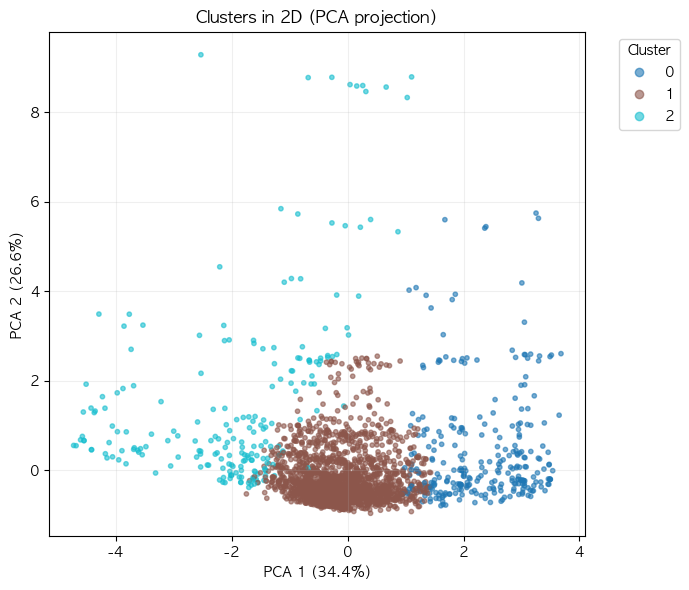

In [9]:
dfv = df_with_cluster.dropna(subset=["cluster"] + num_cols + cat_cols).copy()
X_num = StandardScaler().fit_transform(dfv[num_cols])
X_bin = dfv[cat_cols].values.astype(float)
X_plot = np.hstack([X_num, X_bin])

pca = PCA(n_components=2, random_state=42)
xy = pca.fit_transform(X_plot)

plt.figure(figsize=(7,6))
scatter = plt.scatter(xy[:,0], xy[:,1], c=dfv["cluster"], s=10, alpha=0.6, cmap="tab10")
plt.xlabel("PCA 1 (%.1f%%)" % (pca.explained_variance_ratio_[0]*100))
plt.ylabel("PCA 2 (%.1f%%)" % (pca.explained_variance_ratio_[1]*100))
plt.title("Clusters in 2D (PCA projection)")
plt.legend(*scatter.legend_elements(), title="Cluster", bbox_to_anchor=(1.05,1), loc="upper left")
plt.grid(alpha=0.2)
plt.tight_layout()
plt.show()

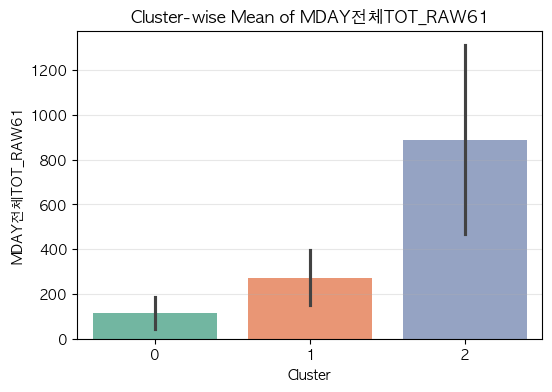

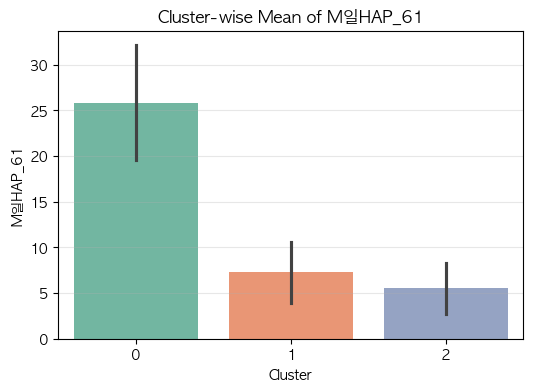

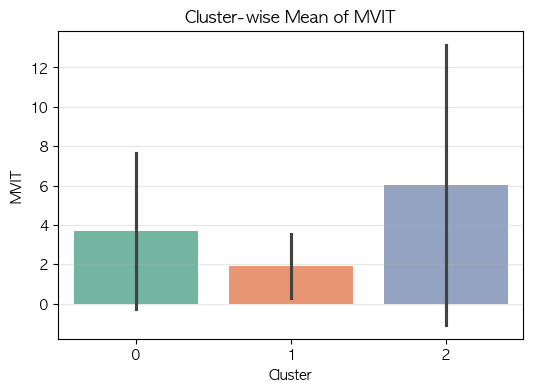

In [10]:
# 클러스터별 평균/표준편차 집계
cluster_stats = df_with_cluster.groupby("cluster")[num_cols].agg(["mean", "std"])

for col in num_cols:
    plt.figure(figsize=(6,4))
    sns.barplot(
        data=df_with_cluster, 
        x="cluster", y=col, 
        ci="sd",  # 표준편차 표시
        palette="Set2"
    )
    plt.title(f"Cluster-wise Mean of {col}")
    plt.xlabel("Cluster")
    plt.ylabel(col)
    plt.grid(axis="y", alpha=0.3)
    plt.show()

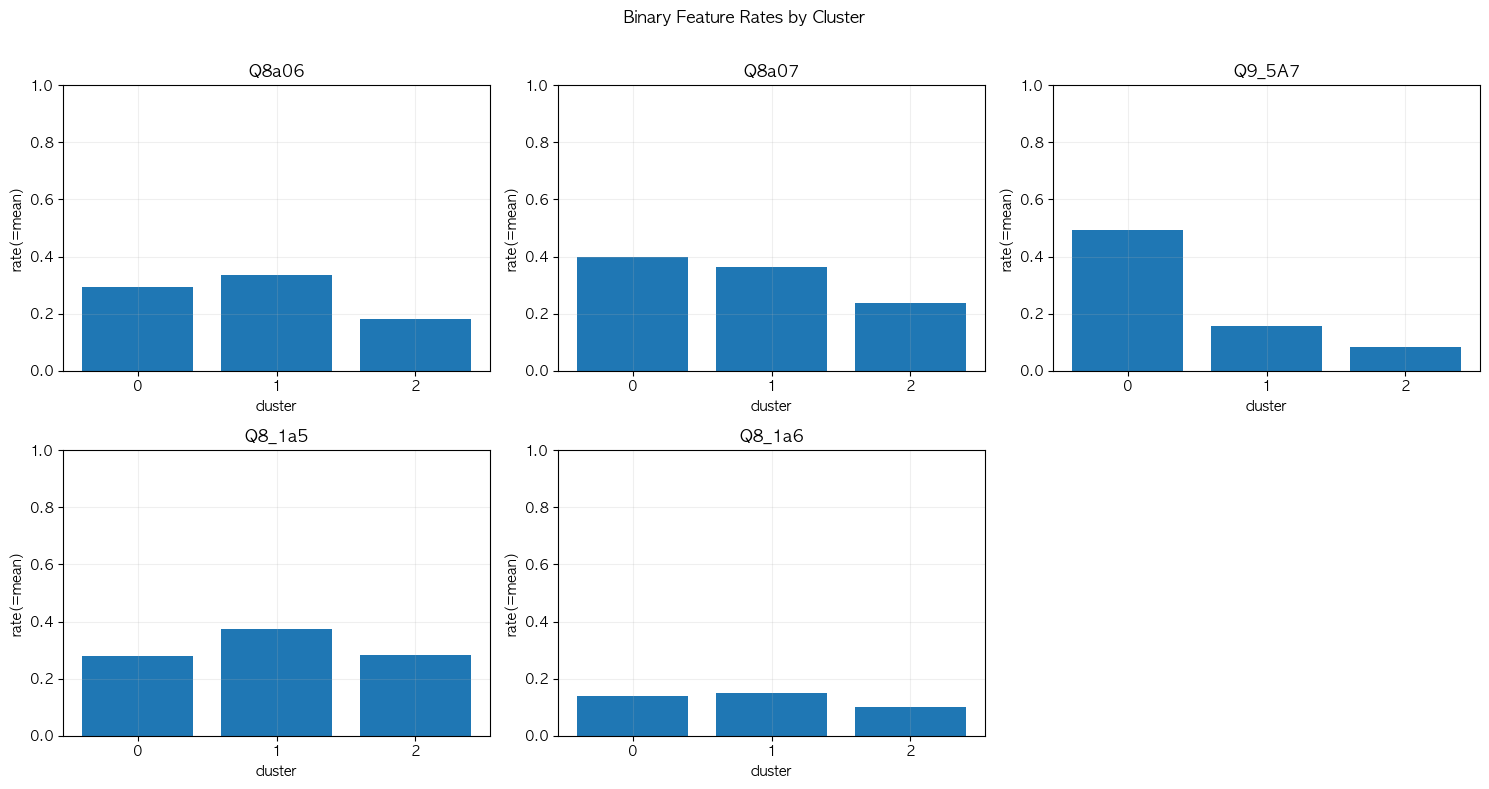

In [11]:
# 변수별 막대 분포
cat_rates = prof_cat.reset_index().melt(id_vars="cluster", var_name="variable", value_name="rate")
cat_rates["variable"] = cat_rates["variable"].str.replace("_rate$", "", regex=True)

vars_to_show = cat_rates["variable"].unique().tolist()

nrow = int(np.ceil(len(vars_to_show)/3))
plt.figure(figsize=(15, 4*nrow))
for i, v in enumerate(vars_to_show, 1):
    plt.subplot(nrow, 3, i)
    tmp = cat_rates[cat_rates["variable"]==v].sort_values("cluster")
    plt.bar(tmp["cluster"].astype(str), tmp["rate"])
    plt.ylim(0, 1)
    plt.title(v)
    plt.xlabel("cluster"); plt.ylabel("rate(=mean)")
    plt.grid(alpha=0.2)
plt.suptitle("Binary Feature Rates by Cluster")
plt.tight_layout(rect=[0,0,1,0.97])
plt.show()